Base paper - https://arxiv.org/pdf/1707.02131.pdf


In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from glob import glob
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

In [3]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
test_images_path = "../input/signature-verification-dataset/sign_data/test/"
train_images_path = "../input/signature-verification-dataset/sign_data/train/"
train_path = "../input/signature-verification-dataset/sign_data/train_data.csv"
test_path = "../input/signature-verification-dataset/sign_data/test_data.csv"

In [5]:
column_names = ["img1", "img2", "label"]
train_data = pd.read_csv(train_path, names=column_names)
test_data = pd.read_csv(test_path, names=column_names)

In [6]:
train_data.head()

,img1,img2,label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23206 entries, 0 to 23205
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img1    23206 non-null  object
 1   img2    23206 non-null  object
 2   label   23206 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 544.0+ KB


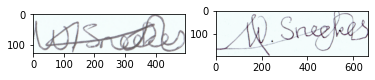

In [8]:
fig, axes = plt.subplots(1,2)
img1 = np.array(Image.open(train_images_path + "068/09_068.png"))
img2 = np.array(Image.open(train_images_path + "068_forg/03_0113068.PNG"))
axes[0].imshow(img1)
axes[1].imshow(img2)

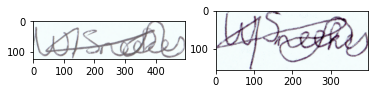

In [9]:
fig, axes = plt.subplots(1,2)
img1 = np.array(Image.open(train_images_path + "068/09_068.png"))
img2 = np.array(Image.open(train_images_path + "068_forg/01_0124068.PNG"))
axes[0].imshow(img1)
axes[1].imshow(img2)

We have images of different sizes. Need to convert to same size.

In [210]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img1 = Image.open(train_images_path + self.data["img1"][idx])
        img2 = Image.open(train_images_path + self.data["img2"][idx])
        label = self.data["label"][idx]
        
        # Apply image transformations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [211]:
size = (155, 220)
resize = transform=transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor()
                                     ])
train_dataset = SiameseNetworkDataset(train_data, train_images_path, transform=resize)
test_dataset = SiameseNetworkDataset(test_data, test_images_path, transform=resize)

In [226]:
def visualize_pair(img1, img2, label):
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(np.transpose(img1.numpy(), (1, 2, 0)))
    axes[1].imshow(np.transpose(img2.numpy(), (1, 2, 0)))
    if label:
        fig.suptitle('Forged', y=0.7)
    else:
        fig.suptitle('Original', y=0.7)

In [235]:
img1.shape

torch.Size([3, 155, 220])

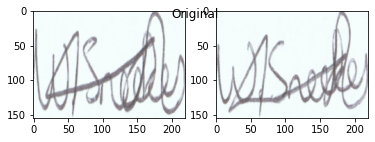

In [229]:
img1, img2, label = train_dataset[100]
visualize_pair(img1, img2, label)

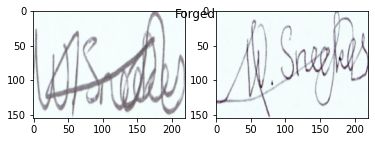

In [230]:
img1, img2, label = train_dataset[0]
visualize_pair(img1, img2, label)

In [231]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)

### Architecture of SigNet:
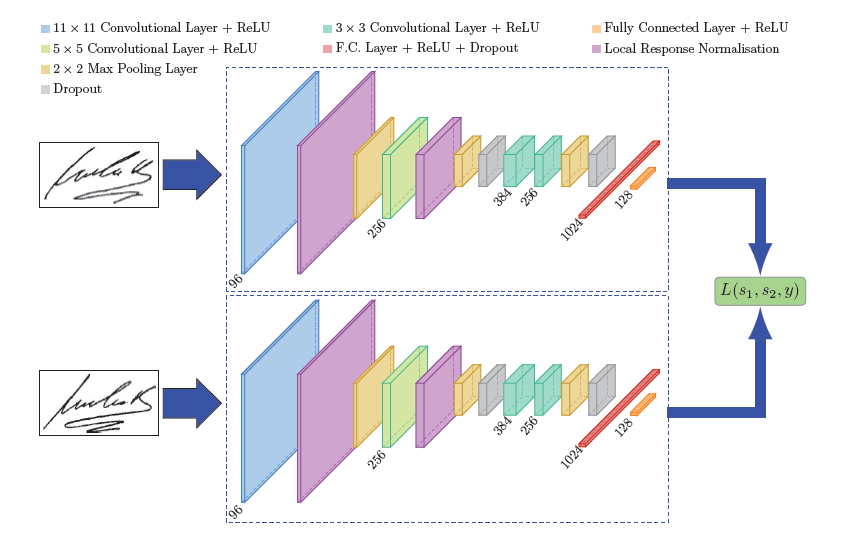
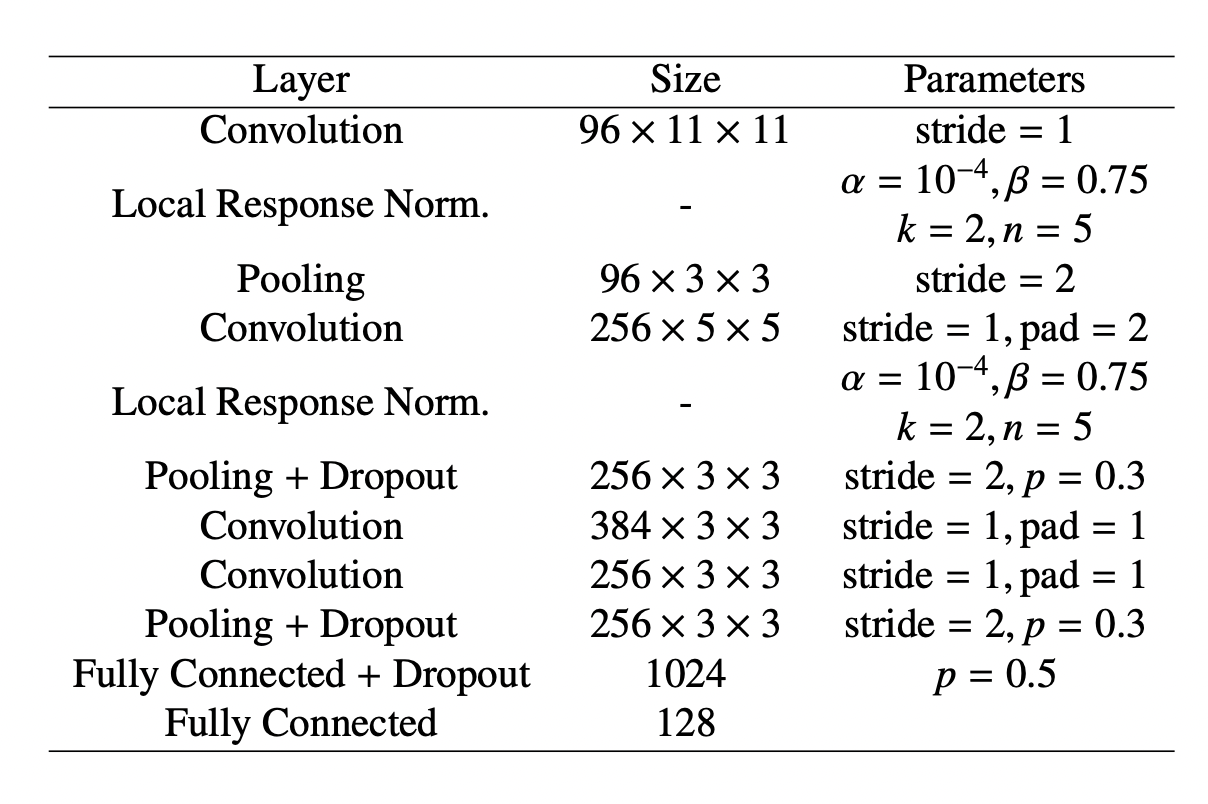

In [256]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3, inplace=True),
        )
        
        self.fc = nn.Sequential(
            
            nn.Linear(108800, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2)
        )
        
    def forward_once(self, image):
            image = torch.tensor(image).float()
            y = self.cnn(image)
            y = y.reshape(1, 108800)
            y = self.fc(y)
            return y
        
    def forward(self, img1, img2):
        y1 = self.forward_once(img1)
        y2 = self.forward_once(img2)
        
        return y1, y2
            
    

In [257]:
model = SiameseNetwork()

In [259]:
y1, y2 = model(img1, img2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [262]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [263]:
Loss = ContrastiveLoss()

In [264]:
Loss(y1, y2, label)

tensor(3.9691, grad_fn=<MeanBackward0>)